# Cross-entropy kernel fit

In [88]:
import numpy as np
import jax.numpy as jnp
import jax
from typing import Callable, Tuple, Dict, Any, Optional
import sys
from pathlib import Path

sys.path.insert(0, str(Path('..') / 'src'))
# Enable 64-bit (double) precision in JAX
jax.config.update("jax_enable_x64", True)

In [89]:
from kl_decomposition import rectangle_rule, gauss_legendre_rule_multilevel

ImportError: cannot import name 'gauss_legendre_rule_multilevel' from 'kl_decomposition' (/home/ber0061/Repositories/KL_decomposition/notebooks/../src/kl_decomposition/__init__.py)

In [90]:
def cross_entropy(
    user_fn: Callable[[np.ndarray], Tuple[np.ndarray, np.ndarray, Dict[str, Any]]],
    initial_mean: np.ndarray,
    initial_std: np.ndarray,
    pop_size: int = 100,
    elite_frac: float = 0.2,
    alpha_mean: float = 0.7,
    alpha_std: float = 0.7,
    n_iters: int = 100,
    random_state: Optional[int] = None,
    verbose: bool = False,
    tol_std: float = 1e-6,
    tol_g: float = 1e-6
) -> Tuple[np.ndarray, float, Dict[str, Any]]:
    """
    Cross-Entropy Method with independent Gaussian distribution and stopping criteria.

    Args:
        user_fn: function taking samples (shape Nxd) and returning
            (updated_samples, scores, info_dict)
        initial_mean: initial mean vector (d,)
        initial_std: initial std deviation vector (d,)
        pop_size: number of samples per iteration
        elite_frac: fraction of samples selected as elites
        alpha_mean: learning rate for mean update
        alpha_std: learning rate for std update
        n_iters: maximum number of iterations
        random_state: RNG seed for reproducibility
        verbose: print debug info each iteration
        tol_std: stop if max(std) <= tol_std
        tol_g: stop if info_dict['normg'] <= tol_g

    Returns:
        best_sample: best found sample (d,)
        best_score: best objective value
        info: dict with:
            'iter': iteration index at stop
            'best_score_history': list of best_score after each iteration
            'max_std_history': list of max_std after each iteration
    """
    rng = np.random.RandomState(random_state)
    mean = np.array(initial_mean, dtype=float)
    std = np.array(initial_std, dtype=float)
    n_elite = max(1, int(np.ceil(pop_size * elite_frac)))
    best_sample: Optional[np.ndarray] = None
    best_score = np.inf

    # history lists
    best_score_history: list = []
    max_std_history: list = []

    for iteration in range(n_iters):
        samples = rng.randn(pop_size, mean.size) * std + mean
        samples, scores, info_dict = user_fn(samples)
        idx = int(np.argmin(scores))
        # update best if improved
        if scores[idx] < best_score:
            best_score = float(scores[idx])
            best_sample = samples[idx]
        # select elites and update distribution
        elite = samples[np.argsort(scores)[:n_elite]]
        elite_mean = elite.mean(axis=0)
        elite_std = elite.std(axis=0, ddof=0)
        mean = alpha_mean * elite_mean + (1 - alpha_mean) * mean
        std = alpha_std * elite_std + (1 - alpha_std) * std
        # record history
        max_std = float(np.max(std))
        best_score_history.append(best_score)
        max_std_history.append(max_std)
        # debug print
        if verbose:
            print(f"Iter {iteration}: best_score={best_score}, max_std={max_std}, info={info_dict}")
        # stopping criteria
        if max_std <= tol_std:
            break
        if info_dict.get('normg', np.inf) <= tol_g:
            break

    info = {
        'iter': iteration,
        'best_score_history': best_score_history,
        'max_std_history': max_std_history
    }
    return best_sample, best_score, info

In [91]:
# setup squared exponential approximation
# x, w = rectangle_rule(0.0, 2.0, 500)
x, w = gauss_legendre_rule_multilevel(0.0, 1.0, 100, L=5, ratio=0.2)

target = np.exp(-x)

# Convert to JAX arrays with float64 dtype
x_j = jnp.array(x, dtype=jnp.float64)
w_j = jnp.array(w, dtype=jnp.float64)
target_j = jnp.array(target, dtype=jnp.float64)


def obj_jax(p):
    # p is already float64
    n_param = p.shape[0] // 2
    a = p[:n_param]
    b = p[n_param:]
    # compute prediction and weighted RMS error
    pred = jnp.sum(a[:, None] * jnp.exp(-b[:, None] * x_j[None, :] ** 2), axis=0)
    diff = pred - target_j
    return jnp.sqrt(jnp.sum(w_j * diff ** 2))


# gradients and Hessians in double precision
grad_jax = jax.jit(jax.grad(obj_jax))
hess_jax = jax.jit(jax.hessian(obj_jax))
obj_jax_jit = jax.jit(obj_jax)


def obj(p):
    # ensure NumPy→JAX conversion to float64
    return float(obj_jax_jit(jnp.array(p, dtype=jnp.float64)))


def grad(p):
    return np.array(grad_jax(jnp.array(p, dtype=jnp.float64)))


def hess(p):
    return np.array(hess_jax(jnp.array(p, dtype=jnp.float64)))

NameError: name 'gauss_legendre_rule_multilevel' is not defined

In [92]:
import numpy as np
def golden_section_search(f, a=0.0, b=1.0, tol=1e-6, max_iter=100):
    """
    Golden-section search to find the minimum of a unimodal function f on [a, b].

    Parameters
    ----------
    f : callable
        The objective function to minimize.
    a : float
        Left endpoint of the initial interval.
    b : float
        Right endpoint of the initial interval.
    tol : float
        Tolerance for the interval width (stopping criterion).
    max_iter : int
        Maximum number of iterations.

    Returns
    -------
    x_min : float
        Estimated position of the minimum.
    f_min : float
        Value of f at x_min.
    """
    # Golden ratio constant
    phi = (np.sqrt(5.0) - 1) / 2

    # Initialize interior points
    c = b - phi * (b - a)
    d = a + phi * (b - a)
    f_c = f(c)
    f_d = f(d)

    for _ in range(max_iter):
        if abs(b - a) < tol:
            break

        if f_c < f_d:
            b, d, f_d = d, c, f_c
            c = b - phi * (b - a)
            f_c = f(c)
        else:
            a, c, f_c = c, d, f_d
            d = a + phi * (b - a)
            f_d = f(d)

    # Choose the best of the final points
    if f_c < f_d:
        x_min, f_min = c, f_c
    else:
        x_min, f_min = d, f_d
    # print(f"Iterations: {_ + 1}")
    return x_min, f_min


def newton(f, grad, hess, x0,
                                   tol_grad=1e-6,
                                   tol_step=1e-8,
                                   stall_iter=5,
                                   max_iter=100,
                                   ls_bounds=(-1.0, 1.0),
                                   verbose=False):
    """
    Newton's method with backtracking line search and fallback to gradient descent.

    Parameters
    ----------
    f : callable
        Objective function f(x).
    grad : callable
        Gradient of f: grad(x).
    hess : callable
        Hessian of f: hess(x).
    x0 : ndarray
        Initial guess.
    tol_grad : float, optional
        Tolerance for gradient norm.
    tol_step : float, optional
        Tolerance for step size norm for stall criterion.
    stall_iter : int, optional
        Number of consecutive small steps to trigger stop.
    max_iter : int, optional
        Maximum number of iterations.
    ls_bounds : (float, float), optional
        Initial interval for line search.

    Returns
    -------
    x : ndarray
        Estimated minimizer.
    grad_norm : float
        Norm of gradient at the solution.
    f_history : list of float
        History of f values.
    grad_norm_history : list of float
        History of gradient norms.
    """
    x = x0.astype(float)
    f_history = []
    grad_norm_history = []
    fx = f(x)

    stall_count = 0
    trust = 1e-6 * np.eye(len(x))  # trust region to ensure positive definiteness

    for k in range(max_iter):
        gx = grad(x)
        grad_norm = np.linalg.norm(gx)

        f_history.append(fx)
        grad_norm_history.append(grad_norm)

        # Check gradient convergence
        if grad_norm < tol_grad:
            break

        # Try Newton step
        try:
            Hx = hess(x)
            p = -np.linalg.solve(Hx + trust, gx)
            trust /= 2
            # ensure descent direction
            # if np.dot(p, gx) >= 0:
            #     raise np.linalg.LinAlgError
        except np.linalg.LinAlgError:
            # fallback to steepest descent
            print("Hessian not positive definite, using gradient descent")
            p = -gx
            trust *= 2
        # Backtracking line search
        alpha, fx = golden_section_search(
            lambda alpha: f(x + alpha * p),
            a=ls_bounds[0], b=ls_bounds[1], tol=1e-6, max_iter=100
        )

        # Update
        x_new = x + alpha * p
        step_norm = np.linalg.norm(x_new - x)
        x = x_new

        # Stall criterion
        if step_norm < tol_step:
            stall_count += 1
            if stall_count >= stall_iter:
                break
        else:
            stall_count = 0

        # print debug info
        if verbose:
            print(f"Iter {k}: f={fx:.6e}, grad_norm={grad_norm:.6e}, step_norm={step_norm:.6e}, alpha={alpha:.6f}")

    return x, grad_norm, f_history, grad_norm_history

In [93]:
import numpy as np

from scipy.optimize import nnls


def optimal_a(d: np.ndarray,
              w: np.ndarray,
              target: np.ndarray,
              b: np.ndarray) -> np.ndarray:
    """
    Solve for a >= 0 minimizing
        sum_j w[j] * (sum_k a[k] * exp(-b[k] * d[j]**2) - target[j])**2

    Parameters
    ----------
    d : (J,) array
        Sample points x_j.
    w : (J,) array
        Quadrature weights.
    target : (J,) array
        Target values at each d[j].
    b : (K,) array
        Exponents b_k.

    Returns
    -------
    a : (K,) array
        Non-negative coefficient vector minimizing the weighted LS error.
    """
    # Build design matrix Φ[j,k] = exp(-b[k] * d[j]**2)
    # Note: np.outer(d**2, b) yields shape (J, K)
    Phi = np.exp(-np.outer(d**2, b))     # shape (J, K)

    # Incorporate weights by scaling rows
    W_sqrt = np.sqrt(w)                  # shape (J,)
    Phi_w = Phi * W_sqrt[:, None]        # shape (J, K)
    y_w = target * W_sqrt              # shape (J,)

    a, _ = nnls(Phi_w, y_w)

    return a

In [94]:
# --- synthetic data ---------------------------------------------------
n_terms = 8               # number of (a_i, b_i) pairs
N       = 500               # data points

d, w = rectangle_rule(0.0, 2.0, N)
target = np.exp(-d)                  # any reference curve you like

b = np.linspace(-1.5, 8.5, n_terms)
a = optimal_a(d, w, target, np.exp(b))
print("Optimal a:", a)

means = np.concatenate((a, np.exp(b)))  # initial guess in log-space

# --- optimiser call ---------------------------------------------------
x, grad_norm, f_history, grad_norm_history = newton(
    f=obj,
    grad=grad,
    hess=hess,
    x0=means,
    tol_grad=1e-5,
    tol_step=1e-8,
    stall_iter=50,
    max_iter=3000,
    ls_bounds=(-2.0, 2.0)
)

print("Optimised parameters:", x)
print("Final gradient norm:", grad_norm)
print("Final objective value:", f_history[-1])

Optimal a: [0.30869798 0.29722181 0.20486527 0.08991123 0.05465842 0.02056889
 0.0121404  0.00894426]
Optimised parameters: [3.10225891e-01 2.98387520e-01 1.69149729e-01 1.00889328e-01
 6.00502670e-02 3.38693342e-02 1.75737668e-02 8.08160829e-03
 2.19150992e-01 9.71349013e-01 3.38629379e+00 1.11679741e+01
 4.03597861e+01 1.74832291e+02 1.02682243e+03 1.14880284e+04]
Final gradient norm: 2.137253178146468e-06
Final objective value: 7.475518925396078e-05


In [95]:
###############################################################################
#  Cross-Entropy search over log-b with internal Newton polishing
###############################################################################
import numpy as np

# --- problem size -----------------------------------------------------------
n_terms = 8          # K  (= length of b and a)
newton_steps = 1     # how many Newton iterations per sample
pop_size = 100       # CE population
np.random.seed(0)    # reproducibility

# --------------------------------------------------------------------------- #
#  helper: CE user-defined update function operating on log-b only
# --------------------------------------------------------------------------- #


def ce_user_fn(b_log_samples: np.ndarray):
    """
    Parameters
    ----------
    b_log_samples : (N, K) ndarray
        Current population in *log* space.
    Returns
    -------
    updated_log_b : (N, K) ndarray
        Polished & sorted log-b that CE will keep using.
    scores        : (N,)  ndarray
        Objective values after polishing (smaller is better).
    info          : dict
        Contains minimum gradient norm among all samples (for CE stopping).
    """
    N, K = b_log_samples.shape
    updated = np.empty_like(b_log_samples)
    scores = np.empty(N)
    grad_norm = np.empty(N)

    for i in range(N):
        # ---- (1) build starting point --------------------------------------
        b_pos = np.exp(b_log_samples[i])            # (K,)  positive
        a_opt = optimal_a(d, w, target, b_pos)      # (K,)
        p0 = np.concatenate([a_opt, b_pos])      # shape (2K,)

        # ---- (2) limited Newton polishing ----------------------------------
        p_new, gnorm, *_ = newton(
            f=obj,
            grad=grad,
            hess=hess,
            x0=p0,
            max_iter=newton_steps,
            tol_grad=1e-6,
            tol_step=1e-6,
            stall_iter=newton_steps,
            ls_bounds=(-2., 2.),
            verbose=False
        )

        if not np.any(np.isnan(p_new)) and not np.any(np.isinf(p_new)) and not np.any(p_new < 0):
            # ---- (3) extract & sort b (log) ------------------------------------
            b_new_pos = np.clip(p_new[K:], 1e-12, None)  # keep positivity
            b_new_log = np.log(b_new_pos)
            order = np.argsort(b_new_log)
            a_opt = optimal_a(d, w, target, b_new_pos)      # (K,)
            p0 = np.concatenate([a_opt, b_new_pos])      # shape (2K,)

            updated[i] = b_new_log[order]
            scores[i] = obj(p0)       # score *after* polishing
            grad_norm[i] = np.linalg.norm(grad(p0))
        else:
            # if polishing failed, keep the original sample
            updated[i] = b_log_samples[i]
            scores[i] = np.inf
            grad_norm[i] = np.inf

    info = {'normg': float(grad_norm.min())}
    return updated, scores, info


# --------------------------------------------------------------------------- #
#  CE initial distribution over log-b
# --------------------------------------------------------------------------- #
init_mean = np.linspace(-1.5, 9.3, n_terms)   # rough guess ⇒ b in ~[0.1, 400]
init_std = np.full(n_terms, 1.0)

# --------------------------------------------------------------------------- #
#  Run Cross-Entropy
# --------------------------------------------------------------------------- #
best_b_log, best_score, ce_info = cross_entropy(
    user_fn=ce_user_fn,
    initial_mean=init_mean,
    initial_std=init_std,
    pop_size=pop_size,
    elite_frac=0.2,
    alpha_mean=0.5,
    alpha_std=0.5,
    n_iters=2000,
    random_state=1234,
    tol_g=1e-6,
    tol_std=1e-6,
    verbose=True      # prints per-iteration progress
)

# --------------------------------------------------------------------------- #
#  Report results
# --------------------------------------------------------------------------- #
best_b = np.exp(best_b_log)
best_a = optimal_a(d, w, target, best_b)
best_obj = obj(np.concatenate([best_a, best_b]))

print("\n====================  CE RESULT  ====================")
print("best log-b :", best_b_log)
print("best b     :", best_b)
print("best a     :", best_a)
print("CE score   :", best_score)
print("check obj  :", best_obj)
print("stopped at iteration", ce_info['iter'],
      "| max σ =", ce_info['max_std_history'][-1])

Iter 0: best_score=0.0020663383290931646, max_std=1.1194314581028086, info={'normg': 0.011281318557269304}
Iter 1: best_score=0.0007770418764170127, max_std=1.1511364273847824, info={'normg': 0.015496623954502053}
Iter 2: best_score=0.0007770418764170127, max_std=1.2365883407129248, info={'normg': 0.008258056031732063}
Iter 3: best_score=0.0007770418764170127, max_std=1.1319599246136318, info={'normg': 0.0035958250549794645}
Iter 4: best_score=0.0007770418764170127, max_std=0.9798253044328744, info={'normg': 0.008309589959640581}
Iter 5: best_score=0.0007770418764170127, max_std=0.8886340742008446, info={'normg': 0.0032590883718469892}
Iter 6: best_score=0.0006641033341269383, max_std=0.8163629178722767, info={'normg': 0.002413255283910929}
Iter 7: best_score=0.0006641033341269383, max_std=0.7665072047209212, info={'normg': 0.004959494979999307}
Iter 8: best_score=0.0006641033341269383, max_std=0.6773439130717271, info={'normg': 0.005257629564780106}
Iter 9: best_score=0.00066410333412

In [96]:
best_b_log

array([-1.48353019,  0.04141208,  1.34315267,  2.62557281,  4.04747186,
        5.72257207,  7.78431983, 10.25991933])

In [97]:
###############################################################################
#  Differential-Evolution optimiser that works with the same `user_fn`
###############################################################################
from typing import Callable, Tuple, Dict, Any, Optional
import numpy as np


def differential_evolution(
    user_fn: Callable[[np.ndarray],
                      Tuple[np.ndarray, np.ndarray, Dict[str, Any]]],
    initial_mean: np.ndarray,
    initial_std: np.ndarray,
    pop_size: int = 100,
    F: float = 0.8,                 # differential weight
    CR: float = 0.9,                # crossover probability
    n_iters: int = 500,
    random_state: Optional[int] = None,
    tol_g: float = 1e-6,            # stop if min‖g‖ drops below this
    stall_generations: int = 50,    # stop if no improvement for so many gens
    verbose: bool = False
) -> Tuple[np.ndarray, float, Dict[str, Any]]:
    """
    Differential Evolution (DE/rand/1/bin) with the CE-style `user_fn`.

    Returns
    -------
    best_sample : ndarray
        The best parameter vector found (d,).
    best_score  : float
        Objective value of `best_sample`.
    info        : dict
        Diagnostics (`iter`, `best_score_history`).
    """
    rng = np.random.RandomState(random_state)
    d = initial_mean.size

    # --- initial population --------------------------------------------------
    pop = rng.randn(pop_size, d) * initial_std + initial_mean       # (N, d)
    pop, scores, info = user_fn(pop)                               # polish & score
    best_idx = int(np.argmin(scores))
    best_sample = pop[best_idx].copy()
    best_score = float(scores[best_idx])

    best_score_history = [best_score]
    no_improve = 0

    for it in range(1, n_iters + 1):
        # ------------ mutation & crossover ----------------------------------
        trial = np.empty_like(pop)
        for i in range(pop_size):
            # choose three *distinct* indices ≠ i
            r1, r2, r3 = rng.choice([j for j in range(pop_size) if j != i],
                                    size=3, replace=False)
            mutant = pop[r1] + F * (pop[r2] - pop[r3])

            # binomial crossover
            cross_pts = rng.rand(d) < CR
            cross_pts[rng.randint(0, d)] = True      # ensure at least one gene
            trial[i] = np.where(cross_pts, mutant, pop[i])

        # ------------ evaluate trial population ------------------------------
        trial, trial_scores, info_trial = user_fn(trial)

        # ------------ selection ----------------------------------------------
        improved = trial_scores < scores
        pop[improved] = trial[improved]
        scores[improved] = trial_scores[improved]

        # ------------ keep track of best -------------------------------------
        gen_best_idx = int(np.argmin(scores))
        gen_best_score = float(scores[gen_best_idx])
        if gen_best_score + 1e-12 < best_score:      # strict improvement
            best_score = gen_best_score
            best_sample = pop[gen_best_idx].copy()
            no_improve = 0
        else:
            no_improve += 1

        best_score_history.append(best_score)

        if verbose:
            print(f"Gen {it:4d}  best={best_score:.4e} "
                  f"min‖g‖={info_trial.get('normg', np.inf):.2e}")

        # ------------ stopping criteria --------------------------------------
        if info_trial.get('normg', np.inf) <= tol_g:
            if verbose:
                print("Stopping: gradient norm below tol_g")
            break
        if no_improve >= stall_generations:
            if verbose:
                print("Stopping: no improvement for",
                      stall_generations, "generations")
            break

    info = {
        'iter': it,
        'best_score_history': best_score_history
    }
    return best_sample, best_score, info



In [106]:

###############################################################################
#  TEST SCRIPT  —  optimise log-b with the same `ce_user_fn`
###############################################################################

# --- problem & helper already defined earlier ---------------------------
# n_terms, ce_user_fn, d, w, target, obj … are assumed to be in scope

pop_size = 10
rng_seed = 1234

# --- problem size -----------------------------------------------------------
n_terms = 10          # K  (= length of b and a)
newton_steps = 1     # how many Newton iterations per sample
np.random.seed(1)    # reproducibility

# --------------------------------------------------------------------------- #
#  helper: CE user-defined update function operating on log-b only
# --------------------------------------------------------------------------- #


def ce_user_fn(b_log_samples: np.ndarray):
    """
    Parameters
    ----------
    b_log_samples : (N, K) ndarray
        Current population in *log* space.
    Returns
    -------
    updated_log_b : (N, K) ndarray
        Polished & sorted log-b that CE will keep using.
    scores        : (N,)  ndarray
        Objective values after polishing (smaller is better).
    info          : dict
        Contains minimum gradient norm among all samples (for CE stopping).
    """
    N, K = b_log_samples.shape
    updated = np.empty_like(b_log_samples)
    scores = np.empty(N)
    grad_norm = np.empty(N)

    for i in range(N):
        # ---- (1) build starting point --------------------------------------
        b_pos = np.exp(b_log_samples[i])            # (K,)  positive
        a_opt = optimal_a(d, w, target, b_pos)      # (K,)
        p0 = np.concatenate([a_opt, b_pos])      # shape (2K,)

        # ---- (2) limited Newton polishing ----------------------------------
        p_new, gnorm, *_ = newton(
            f=obj,
            grad=grad,
            hess=hess,
            x0=p0,
            max_iter=newton_steps,
            tol_grad=1e-9,
            tol_step=1e-9,
            stall_iter=newton_steps,
            ls_bounds=(0., 1.),
            verbose=False
        )

        if not np.any(np.isnan(p_new)) and not np.any(np.isinf(p_new)):
            # ---- (3) extract & sort b (log) ------------------------------------
            b_new_pos = np.clip(p_new[K:], 1e-12, None)  # keep positivity
            b_new_log = np.log(b_new_pos)
            order = np.argsort(b_new_log)
            a_opt = optimal_a(d, w, target, b_new_pos)      # (K,)
            p0 = np.concatenate([a_opt, b_new_pos])      # shape (2K,)

            updated[i] = b_new_log[order]
            scores[i] = obj(p0)       # score *after* polishing
            grad_norm[i] = np.linalg.norm(grad(p0))
        else:
            # if polishing failed, keep the original sample
            updated[i] = b_log_samples[i]
            scores[i] = np.inf
            grad_norm[i] = np.inf

    info = {'normg': float(grad_norm.min())}
    return updated, scores, info




init_mean = np.linspace(-1.6, 10.3, n_terms)   # rough guess ⇒ b in ~[0.1, 400]
init_std = np.full(n_terms, 1.0)

best_b_log, best_score, de_info = differential_evolution(
    user_fn=ce_user_fn,
    initial_mean=init_mean,
    initial_std=init_std,
    pop_size=pop_size,
    F=0.8,
    CR=0.9,
    n_iters=5000,
    random_state=rng_seed,
    tol_g=1e-9,
    stall_generations=75,
    verbose=True
)

# --- final reconstruction of a and objective ----------------------------
best_b = np.exp(best_b_log)
best_a = optimal_a(d, w, target, best_b)
best_obj = obj(np.concatenate([best_a, best_b]))

print("\n====================  DE RESULT  ====================")
print("best log-b :", best_b_log)
print("best b     :", best_b)
print("best a     :", best_a)
print("DE score   :", best_score)
print("check obj  :", best_obj)
print("generations:", de_info['iter'])

Gen    1  best=9.6537e-04 min‖g‖=6.92e-03
Gen    2  best=9.6537e-04 min‖g‖=2.76e-03
Gen    3  best=9.6537e-04 min‖g‖=1.96e-03
Gen    4  best=9.6537e-04 min‖g‖=2.69e-03
Gen    5  best=9.6537e-04 min‖g‖=1.17e-02
Gen    6  best=9.6537e-04 min‖g‖=4.55e-03
Gen    7  best=9.6537e-04 min‖g‖=2.55e-03
Gen    8  best=9.6537e-04 min‖g‖=3.06e-03
Gen    9  best=9.6537e-04 min‖g‖=7.91e-03
Gen   10  best=4.8020e-04 min‖g‖=1.73e-03
Gen   11  best=4.8020e-04 min‖g‖=1.90e-03
Gen   12  best=4.8020e-04 min‖g‖=5.38e-03
Gen   13  best=4.8020e-04 min‖g‖=4.27e-03
Gen   14  best=4.7709e-04 min‖g‖=1.81e-03
Gen   15  best=4.7709e-04 min‖g‖=1.34e-03
Gen   16  best=2.7180e-04 min‖g‖=5.12e-03
Gen   17  best=2.7180e-04 min‖g‖=2.42e-03
Gen   18  best=2.7180e-04 min‖g‖=1.39e-03
Gen   19  best=2.7180e-04 min‖g‖=2.92e-03
Gen   20  best=2.7180e-04 min‖g‖=6.96e-03
Gen   21  best=2.7180e-04 min‖g‖=1.94e-03
Gen   22  best=2.7180e-04 min‖g‖=4.90e-03
Gen   23  best=2.7180e-04 min‖g‖=3.03e-03
Gen   24  best=2.7180e-04 min‖g‖=2

In [119]:
newton_steps = 1
n_terms = 16
init_mean = np.linspace(min(best_b_log), max(best_b_log), n_terms)   # rough guess ⇒ b in ~[0.1, 400]
init_std = np.full(n_terms, 1.0)

best_b_log, best_score, de_info = differential_evolution(
    user_fn=ce_user_fn,
    initial_mean=init_mean,
    initial_std=init_std,
    pop_size=pop_size,
    F=0.8,
    CR=0.9,
    n_iters=50000,
    random_state=rng_seed,
    tol_g=1e-9,
    stall_generations=75,
    verbose=True
)

# --- final reconstruction of a and objective ----------------------------
best_b = np.exp(best_b_log)
best_a = optimal_a(d, w, target, best_b)
best_obj = obj(np.concatenate([best_a, best_b]))

print("\n====================  DE RESULT  ====================")
print("best log-b :", best_b_log)
print("best b     :", best_b)
print("best a     :", best_a)
print("DE score   :", best_score)
print("check obj  :", best_obj)
print("generations:", de_info['iter'])

Gen    1  best=6.0186e-04 min‖g‖=2.09e-03
Gen    2  best=3.8717e-04 min‖g‖=3.76e-03
Gen    3  best=3.8717e-04 min‖g‖=5.27e-03
Gen    4  best=3.8717e-04 min‖g‖=4.44e-03
Gen    5  best=2.6389e-04 min‖g‖=2.44e-03
Gen    6  best=2.6389e-04 min‖g‖=3.84e-03
Gen    7  best=2.2729e-04 min‖g‖=4.26e-03
Gen    8  best=2.2729e-04 min‖g‖=5.69e-03
Gen    9  best=1.7054e-04 min‖g‖=6.09e-04
Gen   10  best=1.7054e-04 min‖g‖=4.46e-03
Gen   11  best=1.4158e-04 min‖g‖=1.08e-03
Gen   12  best=1.4158e-04 min‖g‖=2.02e-03
Gen   13  best=1.4158e-04 min‖g‖=3.55e-03
Gen   14  best=8.5726e-05 min‖g‖=1.94e-03
Gen   15  best=8.5726e-05 min‖g‖=2.43e-03
Gen   16  best=8.5726e-05 min‖g‖=1.71e-03
Gen   17  best=8.5726e-05 min‖g‖=3.47e-03
Gen   18  best=8.5726e-05 min‖g‖=1.17e-03
Gen   19  best=7.6590e-05 min‖g‖=7.55e-04
Gen   20  best=7.6590e-05 min‖g‖=1.42e-03
Gen   21  best=7.6590e-05 min‖g‖=2.75e-03
Gen   22  best=4.8359e-05 min‖g‖=6.97e-04
Gen   23  best=4.8359e-05 min‖g‖=1.05e-03
Gen   24  best=4.8359e-05 min‖g‖=1

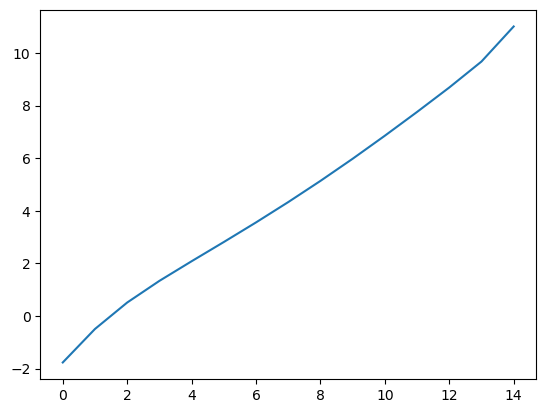

In [118]:
import matplotlib.pyplot as plt
plt.plot(best_b_log)

In [ ]:
g = grad(x)
H = hess(x)
d = np.linalg.solve(H, -g)  # Newton step
dir_obj = lambda alpha: obj(x + alpha * d)
alphas = np.linspace(-1.0, 1.0, 1000)

import matplotlib.pyplot as plt

plt.plot(alphas, [dir_obj(alpha) for alpha in alphas])
plt.xlabel("alpha")
plt.ylabel("Objective along Newton direction")
plt.title("Line search objective along Newton step")
plt.grid()
plt.show()

In [ ]:
N = 500               # data points

d, w = rectangle_rule(0.0, 5.0, N)
target = np.exp(-d)                  # any reference curve you like
f_min_all = []
min_b = -1.0
max_b = 1.5

# --- synthetic data ---------------------------------------------------
for n_terms in range(2, 16):               # number of (a_i, b_i) pairs

    b = np.linspace(min_b * 1.05, max_b * 1.1, n_terms)
    a = optimal_a(d, w, target, np.exp(b))
    # print("Optimal a:", a)

    means = np.concatenate((a, np.exp(b)))  # initial guess in log-space

    # --- optimiser call ---------------------------------------------------
    x, grad_norm, f_history, grad_norm_history = newton(
        f=obj,
        grad=grad,
        hess=hess,
        x0=means,
        tol_grad=1e-5,
        tol_step=1e-8,
        stall_iter=50,
        max_iter=1000,
        ls_bounds=(-2.0, 2.0)
    )
    min_b = min(np.log(x[n_terms:]))
    max_b = max(np.log(x[n_terms:]))
    print(f"Min a log: {min_b}, Max b log: {max_b}")
    print("Final objective value:", f_history[-1])
    f_min_all.append(f_history[-1])

In [ ]:
plt.plot(f_min_all)
plt.yscale('log')

In [ ]:
f_min_all

In [ ]:

# --- synthetic data ---------------------------------------------------

N = 500               # data points

d, w = rectangle_rule(0.0, 2.0, N)
target = np.exp(-d)                  # any reference curve you like
best_init = np.array([0,0])

for n_terms in range(1,10):                 # number of (a_i, b_i) pairs
    means = best_init  # initial mean for (a_i, b_i)
    cov = np.eye(2 * n_terms) * 4  # initial covariance matrix
    # --- optimiser call ---------------------------------------------------
    best, stats = cross_entropy_numba(
        d=d, target=target, w=w,
        n_terms=n_terms,
        max_iter=10000,
        pop_size=10000,
        elite_frac=0.1,
        mean=means,
        cov=cov
    )

    print("Best score :", stats["best_score"])
    print("Best params:", best)
    print("Iterations :", stats["iterations"])
    print("Runtime    :", stats["runtime"], "s")

    first_half = best[:n_terms]
    second_half = best[n_terms:]

    # Original equidistant indices (0 to n_terms-1), new indices from 0 to n_terms
    x_old = np.linspace(0, 1, n_terms)
    x_new = np.linspace(0, 1, n_terms + 1)

    interp_first = np.interp(x_new, x_old, first_half)
    interp_second = np.interp(x_new, x_old, second_half)

    best_init = np.hstack([interp_first, interp_second])

In [ ]:
best_init

In [ ]:
import matplotlib.pyplot as plt
plt.plot(stats["history"])
plt.xlabel("Iteration")
plt.ylabel("Best score")
plt.title("Convergence of the Cross-Entropy Method")
plt.grid()
plt.yscale('log')
plt.show()

In [ ]:
plt.plot(best[n_terms:], 'o-')
plt.xlabel("Index")
plt.ylabel("b_i (log scale)")
plt.title("Fitted b_i parameters")
plt.grid()
plt.show()

In [ ]:
from scipy.optimize import lsq_linear

# compute using least squares the coefficients for approximation with squared exponential kernels
# Construct the design matrix for squared exponential kernels
A = np.zeros((len(d), n_terms))
b_params = np.exp(best[n_terms:])

for i in range(n_terms):
    A[:, i] = np.exp(-b_params[i] * d**2)

# Solve the weighted least squares problem: minimize ||W(Aa - target)||^2
W = np.sqrt(w)
Aw = A * W[:, None]
tw = target * W

res = lsq_linear(Aw, tw, bounds=(0, np.inf))
squared_exponential_coeffs = res.x
print("Squared exponential coefficients:", np.log(squared_exponential_coeffs))

# compute fit with this coefficients
params = np.hstack([np.log(squared_exponential_coeffs), np.log(b_params)])

res = objective_numba(np.array([params]), d, target, w)
print("Objective value with least squares coefficients:", res[0])



In [ ]:
x, w = rectangle_rule(0.0, 2.0, 500)
f = lambda t: np.exp(-t)
a, b, info = fit_exp_sum_ce(5, x, w, f, iterations=2000, pop_size=1000)
print('a:', a)
print('b:', b)
print('best_score:', info.best_score)